In [9]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as s
import scipy.special as ss
import sortedcontainers as sc

In [10]:
from capy import mut, seq

# Load MCMC trace over SNP DP cluster assignments

For now, we are only looking at the high purity exome

In [11]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

# Load coverage

In [12]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"])
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

/mnt/j/local/miniconda3/envs/base38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Load covariates {{{

### Target length

In [13]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

## Replication timing

In [14]:
# load track
F = pd.read_pickle("covars/GSE137764_H1.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

### RT vs. coverage density

/mnt/j/local/miniconda3/envs/base38/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


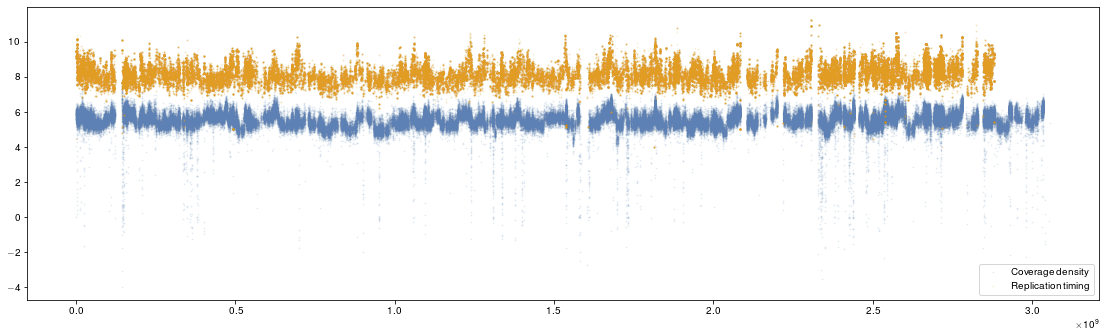

In [17]:
plt.figure(2, figsize = [19.2, 5.39]); plt.clf()
plt.scatter(Cov["start_g"], np.log(Cov["covcorr"]/Cov["C_len"]), s = 1, alpha = 0.1)
plt.scatter(Cov["start_g"], 5*Cov["C_RT"] + 4, alpha = 0.1, s = 1)
plt.legend(["Coverage density", "Replication timing"])

## GC content

In [29]:
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

### GC content vs. coverage density

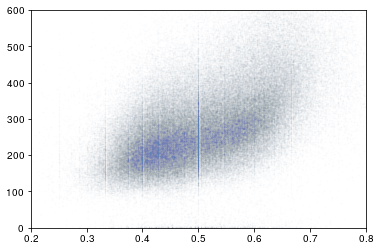

In [30]:
plt.figure(11); plt.clf()
plt.scatter(Cov["C_GC"], Cov["covcorr"]/Cov["C_len"], alpha = 0.01, s = 1)
plt.xlim([0.2,0.8]);
plt.ylim([0,600]);

}}}

# Load SNPs

In [31]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

## Map to targets

In [32]:
SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)
# TODO: handle NaN's better

## Generate unique clust assignments

In [33]:
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

## Assign coverage intervals to clusters

In [34]:
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[:, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

## Subset to intervals containing SNPs

In [35]:
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

## Prune improbable assignments

In [36]:
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

## Plot cluster assignment probabilities

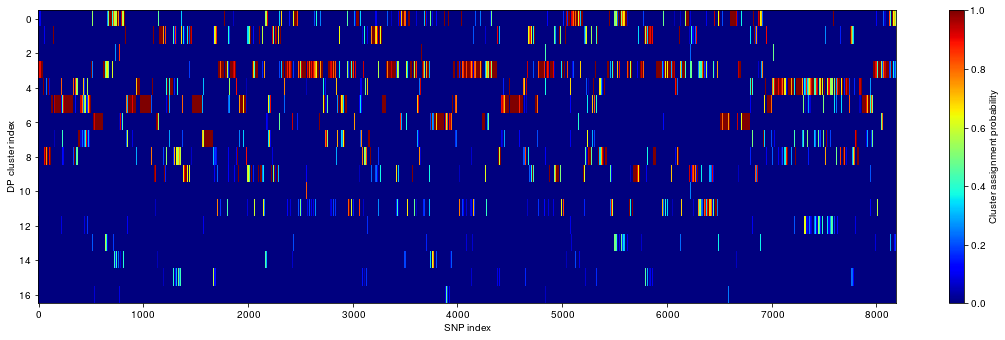

In [47]:
plt.figure(1, figsize = [19.2, 5.39]); plt.clf()
plt.imshow(Cov_clust_probs_overlap[:, Cov_clust_probs_overlap.sum(0) > 0].T, aspect = "auto", interpolation = "none", cmap = "jet")
cb = plt.colorbar();
cb.set_label("Cluster assignment probability");
plt.xlabel("SNP index");
plt.ylabel("DP cluster index");

# Poisson regression

## Subset to only targets that overlap SNPs

In [48]:
Cov_overlap = Cov.loc[overlap_idx, :]

r = np.c_[Cov_overlap["covcorr"]]

## Make covariate matrix

In [49]:
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

# (experimenting with covariate subsets)
#C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_GC_z"]]
#C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"]]

## Cluster assignment vector ($\vec\pi_i$)

In [50]:
Pi = Cov_clust_probs_overlap.copy()

#### Drop NaN's for now

In [51]:
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

## Define optimization functions

In [52]:
# mu gradient
def gradmu(mu, beta, r, C, Pi):
    e = np.exp(C@beta + Pi@mu)
    return Pi.T@(r - e)

# mu Hessian
def hessmu(mu, beta, r, C, Pi): 
    e = np.exp(C@beta + Pi@mu)
    return -Pi.T@np.diag(e.ravel())@Pi

# beta gradient
def gradbeta(beta, mu, r, C, Pi):
    e = np.exp(C@beta + Pi@mu)
    return C.T@(r - e)

# beta Hessian
def hessbeta(beta, mu, r, C, Pi): 
    e = np.exp(C@beta + Pi@mu)
    return -C.T@np.diag(e.ravel())@C

# mu,beta Hessian
def hessmubeta(mu, beta, r, C, Pi):
    e = np.exp(C@beta + Pi@mu)
    return -C.T@np.diag(e.ravel())@Pi

## Fit regression parameters

### Initialize parameters

In [53]:
mu = np.log(r.mean()*np.ones([Pi.shape[1], 1]))
beta = np.ones([C.shape[1], 1])

### Run Newton-Raphson iterations

In [54]:
for i in range(100):
    gmu = gradmu(mu, beta, r, C, Pi)
    gbeta = gradbeta(beta, mu, r, C, Pi)
    grad = np.r_[gmu, gbeta]

    hmu = hessmu(mu, beta, r, C, Pi)
    hbeta = hessbeta(beta, mu, r, C, Pi)
    hmubeta = hessmubeta(mu, beta, r, C, Pi)
    H = np.r_[np.c_[hmu, hmubeta.T], np.c_[hmubeta, hbeta]]

    delta = np.linalg.inv(H)@grad
    mu -= delta[0:len(mu)]
    beta -= delta[len(mu):]

    if np.linalg.norm(grad) < 1e-5:
        break

# Plots

#### Load color palette

In [55]:
colors = mpl.cm.get_cmap("tab10").colors

## Regressed coverage density

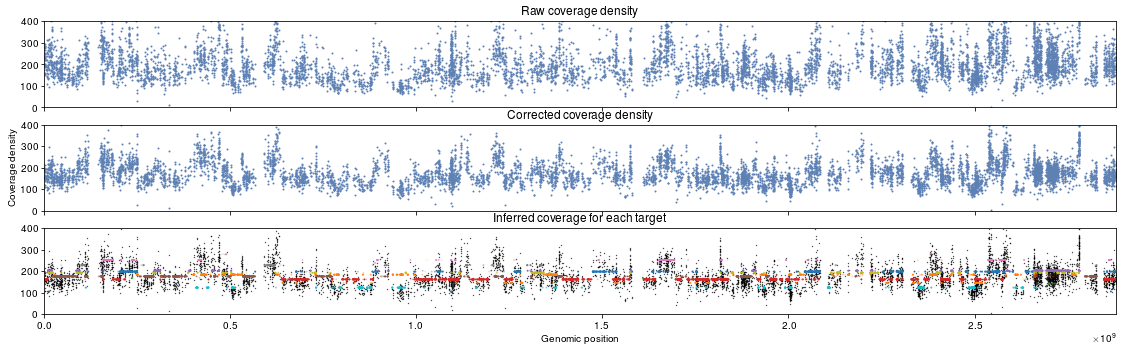

In [66]:
plt.figure(3, figsize = [19.2,  5.39]); plt.clf()
_, axs = plt.subplots(3, 1, sharex = True, sharey = True, num = 3)
axs[0].scatter(Cov_overlap.loc[~naidx, "start_g"], np.exp(np.log(r) - C[:, [0]]@beta[[0]]), alpha = 1, s = 1)
axs[0].set_title("Raw coverage density")

axs[1].scatter(Cov_overlap.loc[~naidx, "start_g"], np.exp(np.log(r) - C@beta), alpha = 1, s = 1)
axs[1].set_title("Corrected coverage density")
axs[1].set_ylabel("Coverage density")

axs[2].scatter(Cov_overlap.loc[~naidx, "start_g"], np.exp(np.log(r) - C@beta), s = 0.1, color = 'k')

for i, p in enumerate(Pi.T):
    nzidx = p > 0
    x = Cov_overlap.loc[~naidx, "start_g"].loc[nzidx]
    axs[2].scatter(x, np.full(len(x), np.exp(mu[i])), alpha = p[nzidx]**4, s = 1, color = np.array(colors)[i % len(colors)])
axs[2].set_title("Inferred coverage density for each target")
axs[2].set_xlabel("Genomic position")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 400]);

Segment colors correspond to their DP cluster. Looking at the allelic imbalance segementation, the red DP cluster is LoH; the brown cluster is balanced. There are some regions of genome doubling, which is why the brown cluster is sitting a little higher than most targets' coverage density

## Residuals

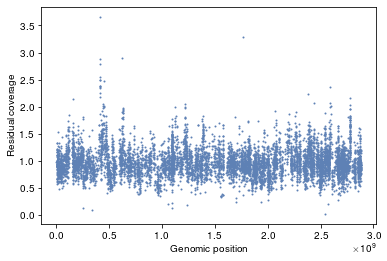

In [69]:
plt.figure(444); plt.clf()
plt.scatter(Cov_overlap.loc[~naidx, "start_g"], np.exp(np.log(r) - (C@beta + Pi@mu)), alpha = 1, s = 1)
plt.xlabel("Genomic position")
plt.ylabel("Residual coverage");

## Predicted vs. residuals

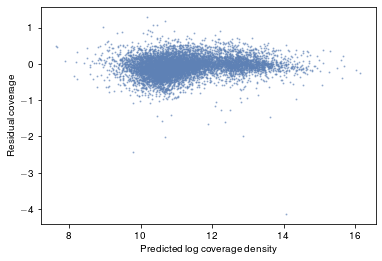

In [68]:
plt.figure(4); plt.clf()
plt.scatter(Pi@mu + C@beta, np.log(r) - (Pi@mu + C@beta), alpha = 0.5, s = 1)
plt.xlabel("Predicted log coverage density")
plt.ylabel("Residual coverage");

## Observed vs. predicted

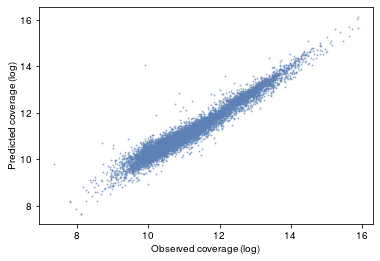

In [62]:
plt.figure(5); plt.clf()
plt.scatter(np.log(r), Pi@mu + C@beta, alpha = 0.5, s = 1)
plt.xlabel("Observed coverage (log)")
plt.ylabel("Predicted coverage (log)");

Scrap code below; interpolate coverage to targets that don't contain SNPs

In [ ]:
bdy = np.unique(np.r_[0, np.flatnonzero(overlap_idx), len(Cov_clust_probs)])
bdy = np.c_[bdy[:-1], bdy[1:]]

In [ ]:
Cov_clust_probs_interp = Cov_clust_probs.copy()

In [ ]:
for st, en in bdy:
    if st == 0:
        Cov_clust_probs_interp[st:en, :] = Cov_clust_probs[en, :]
        continue
    if en == len(Cov_clust_probs):
        Cov_clust_probs_interp[st:en, :] = Cov_clust_probs[st, :]
        continue

    Cov_clust_probs_interp[(st + 1):en, :] = Cov_clust_probs[[st, en], :].mean(0)

In [ ]:
# prune improbable assignments
Cov_clust_probs_interp = Cov_clust_probs_interp[:, prune_idx]

In [ ]:
# define variables/covariates
r_int = np.c_[Cov["covcorr"]]

In [ ]:
# covariates
C_int = np.c_[np.log(Cov["C_len"]), Cov["C_RT_z"], Cov["C_GC_z"]]

In [ ]:
# cluster assignments
Pi_int = Cov_clust_probs_interp.copy()

In [ ]:
# drop NaN's for now
naidx = np.isnan(C_int[:, 1])
r_int = r_int[~naidx]
C_int = C_int[~naidx]
Pi_int = Pi_int[~naidx]

In [ ]:
plt.figure(33); plt.clf()
plt.scatter(Cov.loc[~naidx, "start_g"], Pi_int@mu + C_int[:, [1]]@beta[[1], :], alpha = 1, s = 1)

In [ ]:
_, axs = plt.subplots(3, 1, sharex = True, sharey = True, num = 33)
axs[0].scatter(Cov.loc[~naidx, "start_g"], np.exp(np.log(r_int) - C_int[:, [0]]@beta[[0]]), alpha = 1, s = 1)
axs[0].set_title("Raw coverage density")

In [ ]:
axs[1].scatter(Cov.loc[~naidx, "start_g"], np.exp(np.log(r_int) - C_int@beta), alpha = 1, s = 1)
axs[1].set_title("Corrected coverage density")

In [ ]:
axs[2].scatter(Cov.loc[~naidx, "start_g"], np.exp(np.log(r_int) - C_int@beta), s = 0.1, color = 'k')

In [ ]:
for i, p in enumerate(Pi_int.T):
    nzidx = p > 0
    x = Cov.loc[~naidx, "start_g"].loc[nzidx]
    axs[2].scatter(x, np.full(len(x), np.exp(mu[i])), alpha = p[nzidx]**4, s = 1, color = np.array(colors)[i % len(colors)])
axs[2].set_title("Inferred coverage for each target")

In [ ]:
plt.xlim((0.0, 2879000000.0))
plt.ylim([0, 400])